In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn as sk
from datatools import extract_market_data
from pipeline import Dataset

"""load data"""
dataset = Dataset.load('../../data/parsed')
df = pd.concat([dataset.fundamental, extract_market_data(dataset.market)], axis=1).dropna()
return_df = dataset.ref_return
df_with_return = pd.concat([df, return_df], axis=1).dropna()
new_df = df[(df.index.get_level_values('day') != 999) & (df.index.get_level_values('day') != 1000)]
new_df['log_avg_price'] = np.log(new_df['avg_price'])
df_with_return = df_with_return.drop(columns=['transactionAmount', 'pe_ttm'])
df_with_return['log_avg_price'] = np.log(df_with_return['avg_price'])
df_with_return = df_with_return.drop(columns = ['avg_price'])
df_with_return = df_with_return.drop(columns = ['ps'])
df_with_return['previous_return'] = np.zeros(len(df_with_return))
df_with_return = df_with_return[[c for c in df_with_return if c not in ['return']] + ['return']]
for h in range(54):
    df_with_return['previous_return']  = df_with_return.groupby(level = 'asset').shift(3)['return'].fillna(0)
df_with_return

C:\Users\specf\AppData\Local\Temp\ipykernel_31804\1169974401.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['log_avg_price'] = np.log(new_df['avg_price'])


turnoverRatio        pe      pb       pcf  volatility  mean_volume  \
day asset                                                                       
1   0             3.6794   32.3029  4.9425 -578.7700    0.861989    454075.84   
    1             2.5150   27.2726  5.0552   23.8260    0.804576    176868.36   
    2             1.2858   41.9279  4.8083  -58.2185    0.351893    361648.66   
    3             2.2007   13.8032  2.1904   61.0491    0.250697    351809.54   
    4             0.8627 -433.1736  3.0714  -25.2279    0.270981    338476.86   
...                  ...       ...     ...       ...         ...          ...   
998 49            0.3720   41.1121  2.8312   73.1850    0.511882    108894.60   
    50            0.4780   19.4678  2.5076  -38.0915    0.701618     82457.26   
    51            1.1501   14.5922  1.4130   19.5205    0.323547    390835.44   
    52            0.5684   28.9922  5.7855 -582.4621    0.803932     97800.88   
    53            1.2933   10.6513  1.9956  134.5467    0.542088    252827.46   

           return_0  log_avg_price  previous_return    return  
day asset                                                      
1   0     -0.025231       3.200863         0.000000 -0.026877  
    1     -0.011895       2.783144         0.000000 -0.052674  
    2     -0.018466       2.203778         0.000000 -0.002691  
    3      0.002644       2.210959         0.000000 -0.018515  
    4     -0.023423       1.620262         0.000000 -0.019184  
...             ...            ...              ...       ...  
998 49    -0.014577       2.632819        -0.007664 -0.014799  
    50    -0.013801       2.417723         0.085252  0.012921  
    51    -0.040754       1.319995        -0.024464 -0.052286  
    52     0.004224       3.361956         0.005946 -0.015559  
    53     0.019924       2.284526         0.042851 -0.003662  

[53892 rows x 10 columns]

In [3]:
df_with_return.query("asset==0")

,,turnoverRatio,pe,pb,pcf,volatility,mean_volume,return_0,log_avg_price,previous_return,return
day,asset,,,,,,,,,,
1,0,3.6794,32.3029,4.9425,-578.7700,0.861989,454075.84,-0.025231,3.200863,0.000000,-0.026877
2,0,3.2535,31.2498,4.7814,-559.9031,2.243321,401517.02,-0.032352,3.174435,0.000000,0.028805
3,0,2.4947,23.3887,4.3823,-42.8676,0.522122,307969.24,0.005658,3.162331,0.000000,0.107928
4,0,4.5625,23.9187,4.4816,-43.8390,2.372700,563240.50,0.023017,3.172805,-0.026877,0.068998
5,0,18.2257,25.9119,4.8551,-47.4923,4.485819,2249971.94,0.083000,3.263191,0.028805,-0.027238
...,...,...,...,...,...,...,...,...,...,...,...
994,0,1.6115,64.3030,1.6555,-41.3480,0.333513,330810.62,-0.008667,2.516958,0.001931,-0.026212
995,0,1.4651,63.6287,1.6382,-40.9144,0.455761,300758.86,-0.009702,2.516232,-0.018119,-0.000985
996,0,1.7045,62.5867,1.6113,-40.2444,0.556307,349902.24,-0.016671,2.515440,-0.018285,0.003992


In [10]:
"""implement a function that use ridge kernel regression"""
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
"""use lasso linear regression model to predict the return"""
from sklearn.linear_model import Lasso


class KernelModel:
    def __init__(self, alpha, kernel, gamma):
        self.reg = Lasso(alpha = 0)

    def fit_predict(self, X, y):
        #X = X.copy()
        #X['log_avg_price'] = np.log(X['avg_price'])
        #X['previous_return'] = X['return_0'] + X['return_1'] + X['return_0'] * X['return_1']
        #features = ['turnoverRatio', 'pe', 'pb', 'pcf', 'volatility', 'mean_volume', 'return_0', 'log_avg_price', 'previous_return']
        #X = X[features]
        self.reg.fit(X, y)
        y_pred = self.reg.predict(X)
        return y_pred

    def predict(self, X):
        #X = X.copy()
        #X['log_avg_price'] = np.log(X['avg_price'])
        #X['previous_return'] = X['return_0'] + X['return_1'] + X['return_0'] * X['return_1']
        #features = ['turnoverRatio', 'pe', 'pb', 'pcf', 'volatility', 'mean_volume', 'return_0', 'log_avg_price', 'previous_return']
        #X = X[features]
        return self.reg.predict(X)


features = list(df_with_return.columns)
print(features)

['turnoverRatio', 'pe', 'pb', 'pcf', 'volatility', 'mean_volume', 'return_0', 'log_avg_price', 'previous_return', 'return']


In [11]:
from pipeline.backtest import cross_validation
from visualization.metric import plot_performance
idx = pd.IndexSlice
table = [21, 24, 25, 29, 33]
model = KernelModel(0.1, 'linear', None)
performance_ev, comparison = cross_validation(model, list(set(features) - {'return'}),  df = df_with_return.loc[idx[:, table], :])


  0%|          | 0/996 [00:00<?, ?it/s]C:\Users\specf\AppData\Local\Temp\ipykernel_31804\1223702891.py:18: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.reg.fit(X, y)
C:\Users\specf\anaconda3\envs\qids-2023-comp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
Validation on day 3, train_r2=1.0000, val_r2=-317.3414, val_cum_r2=-317.3414, val_cum_pearson=-0.3140:   0%|          | 1/996 [00:01<28:45,  1.73s/it]C:\Users\specf\AppData\Local\Temp\ipykernel_31804\1223702891.py:18: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.reg.fit(X, y)
C:\Users\specf\anaconda3\envs\qids-2023-comp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordin

In [6]:
from qids_lib import QIDS
qids = QIDS(path_prefix='../../')


In [7]:
from pipeline.backtest import evaluation_for_submission

evaluation_for_submission(model, dataset, qids, lookback_window = 50)

Day 1700, test cum pearson -0.0244: 100%|█████████▉| 699/700 [00:48<00:00, 14.43it/s]

Data Feeding is finished.


-0.07617050653234414
PearsonRResult(statistic=-0.031619997583683924, pvalue=0.025684793960168387)


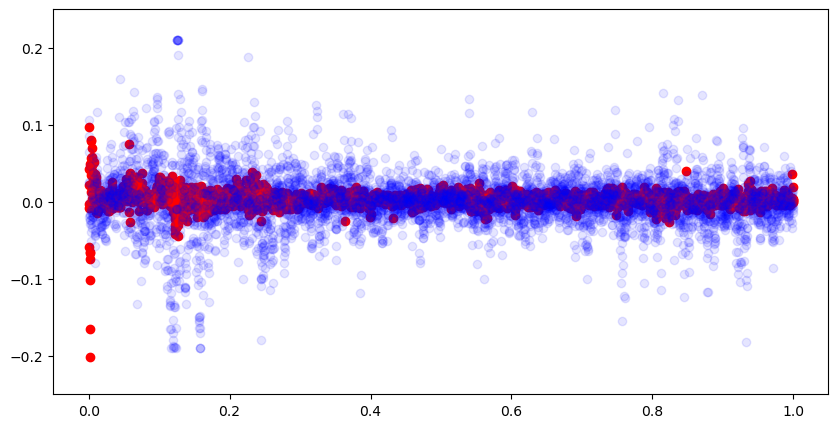

In [72]:

"""clean the outlier"""
comparison = comparison[comparison['cum_y_val_prediction'] < 0.25]
comparison = comparison[comparison['cum_y_val_prediction'] > -0.25]
x = np.linspace(0, 1, len(comparison))
"""compute the R^2 between the prediction and the true value"""
from sklearn.metrics import r2_score
print(r2_score(comparison['cum_y_val_true'], comparison['cum_y_val_prediction']))
"""compute the pearson correlation between the prediction and the true value"""
from scipy.stats import pearsonr
print(pearsonr(comparison['cum_y_val_true'], comparison['cum_y_val_prediction']))

plt.figure(figsize=(10, 5))
plt.scatter(x, comparison['cum_y_val_prediction'], color = 'red')
plt.scatter(x, comparison['cum_y_val_true'], color = 'blue', alpha = 0.1)
plt.ylim(-0.25, 0.25)
plt.show()



The ending score for metric train_r2 is: -1.1081e-01
The ending score for metric val_cum_r2 is: -8.1735e-01
The ending score for metric val_cum_pearson is: -4.0594e-02


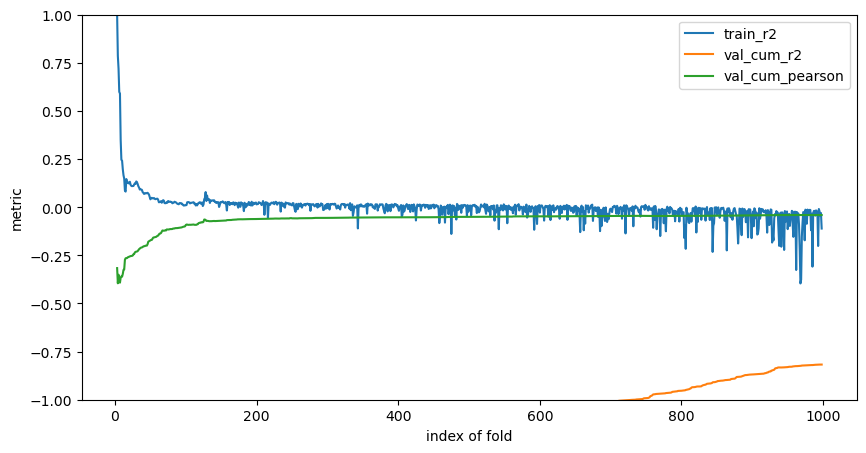

In [73]:
plt.figure(figsize=(10, 5))
plot_performance(performance_ev, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])
plt.ylim(-1, 1)
plt.show()